In [0]:
!git clone https://github.com/kcbharat100/covid-19-detection-using-x-rays.git 

Cloning into 'covid-19-detection-using-x-rays'...
remote: Enumerating objects: 160, done.
remote: Counting objects: 100% (160/160), done.
remote: Compressing objects: 100% (160/160), done.
remote: Total 772 (delta 2), reused 155 (delta 0), pack-reused 612
Receiving objects: 100% (772/772), 193.15 MiB | 12.05 MiB/s, done.
Resolving deltas: 100% (17/17), done.
Checking out files: 100% (711/711), done.


In [0]:
!pip install split-folders
import split_folders

split_folders.ratio('covid-19-detection-using-x-rays/dataset', output="data", seed=1337, ratio=(.7, .15, .15)) # default values
print('Wait until you see data directory...')


Copying files: 426 files [00:00, 1180.64 files/s]

Wait until you see data directory...


In [0]:
#importing packages:
import os
import PIL
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout
from keras.layers import Activation, Flatten, Dense
from keras import optimizers
from keras.applications import VGG16
from keras import Model

In [99]:
#data preparation:

train_dir = 'data/train'
validation_dir = 'data/val'
test_dir = 'data/test'

# as per the image size of VGG16
img_size = (224,224) 
batch_size = 64

classes = sorted(os.listdir(train_dir))
print(classes)

print("Getting data...")
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
	  height_shift_range=0.2,
    fill_mode="nearest")

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

print("Preparing trainig dataset...")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True)

print("Preparing validation dataset...")
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False)

print("Preparing test dataset...")
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False)

['covid', 'normal', 'pneumonia']
Getting data...
Preparing trainig dataset...
Found 297 images belonging to 3 classes.
Preparing validation dataset...
Found 63 images belonging to 3 classes.
Preparing test dataset...
Found 66 images belonging to 3 classes.


In [100]:
#transfer learning using vgg16

#Load the base model, not including its final connected layer, and set the input shape to match our images
base_model = VGG16(weights='imagenet', include_top=False, input_shape=train_generator.image_shape)

# Freeze the already-trained layers in the base model
for layer in base_model.layers:
    layer.trainable = False
    
# Create layers for classification of our images
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
prediction_layer = Dense(train_generator.num_classes, activation='softmax')(x) 
model = Model(inputs=base_model.input, outputs=prediction_layer)

# Compile the model
opt = optimizers.Adam(lr = 1e-5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

#View trainable layers 
for layer in model.layers:
  print("{0}:\t{1}".format(layer.trainable, layer.name))

# Now print the full model, which will include the layers of the base model plus the dense layer we added
print(model.summary())

False:	input_9
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
False:	block5_conv3
False:	block5_pool
True:	flatten_10
True:	dense_19
True:	dropout_10
True:	dense_20
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooli

In [101]:
# Training
num_epochs = 20
history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    epochs = num_epochs)
model.save('first_model.h5')

Epoch 1/20
4/4 [==============================] - 9s 2s/step - loss: 1.2263 - accuracy: 0.3863 - val_loss: 0.9862 - val_accuracy: 0.5714
Epoch 2/20
4/4 [==============================] - 8s 2s/step - loss: 1.1791 - accuracy: 0.4102 - val_loss: 0.9243 - val_accuracy: 0.4762
Epoch 3/20
4/4 [==============================] - 8s 2s/step - loss: 1.0543 - accuracy: 0.4721 - val_loss: 0.7903 - val_accuracy: 0.7619
Epoch 4/20
4/4 [==============================] - 8s 2s/step - loss: 0.9694 - accuracy: 0.5365 - val_loss: 0.7068 - val_accuracy: 0.8095
Epoch 5/20
4/4 [==============================] - 8s 2s/step - loss: 0.7931 - accuracy: 0.6567 - val_loss: 0.6535 - val_accuracy: 0.7778
Epoch 6/20
4/4 [==============================] - 7s 2s/step - loss: 0.7843 - accuracy: 0.6609 - val_loss: 0.6104 - val_accuracy: 0.7778
Epoch 7/20
4/4 [==============================] - 9s 2s/step - loss: 0.7837 - accuracy: 0.6484 - val_loss: 0.5776 - val_accuracy: 0.7619
Epoch 8/20
4/4 [=========================

In [102]:
#evaluation:
_, acc = model.evaluate_generator(validation_generator, steps=validation_generator.samples / batch_size)
print('Validation Accuracy: %.3f' % (acc * 100.0))

_, acc = model.evaluate_generator(test_generator, steps=test_generator.samples / batch_size)
print('Test Accuracy: %.3f' % (acc * 100.0))

Validation Accuracy: 90.476
Test Accuracy: 92.424


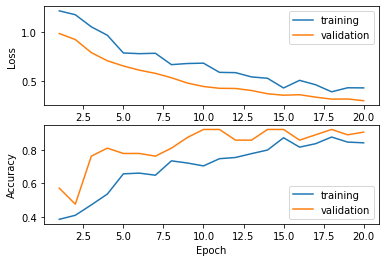

In [103]:
#ploting loss and accuracy
%matplotlib inline

from matplotlib import pyplot as plt

epoch_nums = range(1,num_epochs+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.figure(1)
plt.subplot(211)
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['training', 'validation'], loc='upper right')

epoch_nums = range(1,num_epochs+1)
training_accuracy = history.history["accuracy"]
validation_accuracy = history.history["val_accuracy"]
plt.subplot(212)
plt.plot(epoch_nums, training_accuracy)
plt.plot(epoch_nums, validation_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['training', 'validation'], loc='lower right')
plt.show()
# plt.savefig('plot.png', dpi=300, bbox_inches='tight')

In [104]:
# Fine tuning

# reset our data generators
train_generator.reset()
validation_generator.reset()
test_generator.reset()

#unfreeze some layers
for layer in base_model.layers:
    # Boolean whether this layer is trainable.
    trainable = ('block5' in layer.name or 'block4' in layer.name)
    # trainable = ('block5' in layer.name)
  
    # Set the layer's bool.
    layer.trainable = trainable

#View trainable layers 
for layer in model.layers:
  print("{0}:\t{1}".format(layer.trainable, layer.name))

# Compile the model
opt_fine = optimizers.Adam(lr = 1e-5)
model.compile(optimizer=opt_fine, loss='categorical_crossentropy', metrics=['accuracy'])

# Now print the full model, which will include the layers of the base model plus the dense layer we added
print(model.summary())

False:	input_9
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool
True:	flatten_10
True:	dense_19
True:	dropout_10
True:	dense_20
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   

In [105]:
# Training Fine tuning
num_epochs = 20
history_final = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    epochs = num_epochs)
model.save('final_model.h5')

Epoch 1/20
4/4 [==============================] - 9s 2s/step - loss: 0.3088 - accuracy: 0.8884 - val_loss: 0.2426 - val_accuracy: 0.9365
Epoch 2/20
4/4 [==============================] - 7s 2s/step - loss: 0.3298 - accuracy: 0.8627 - val_loss: 0.2331 - val_accuracy: 0.9206
Epoch 3/20
4/4 [==============================] - 8s 2s/step - loss: 0.2278 - accuracy: 0.9056 - val_loss: 0.1904 - val_accuracy: 0.9365
Epoch 4/20
4/4 [==============================] - 9s 2s/step - loss: 0.2060 - accuracy: 0.9453 - val_loss: 0.2063 - val_accuracy: 0.9206
Epoch 5/20
4/4 [==============================] - 8s 2s/step - loss: 0.2235 - accuracy: 0.9142 - val_loss: 0.1624 - val_accuracy: 0.9365
Epoch 6/20
4/4 [==============================] - 8s 2s/step - loss: 0.1570 - accuracy: 0.9399 - val_loss: 0.1581 - val_accuracy: 0.9365
Epoch 7/20
4/4 [==============================] - 8s 2s/step - loss: 0.1771 - accuracy: 0.9270 - val_loss: 0.1854 - val_accuracy: 0.9365
Epoch 8/20
4/4 [=========================

In [106]:
#evaluation:
_, acc = model.evaluate_generator(validation_generator, steps=validation_generator.samples / batch_size)
print('Validation Accuracy: %.3f' % (acc * 100.0))

_, acc = model.evaluate_generator(test_generator, steps=test_generator.samples / batch_size)
print('Test Accuracy: %.3f' % (acc * 100.0))

Validation Accuracy: 96.825
Test Accuracy: 95.455


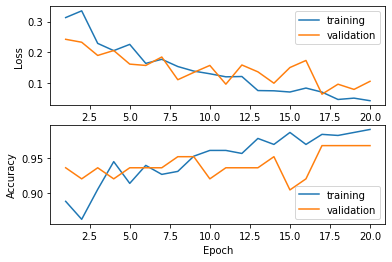

In [107]:
#ploting loss and accuracy
%matplotlib inline

from matplotlib import pyplot as plt

epoch_nums = range(1,num_epochs+1)
training_loss = history_final.history["loss"]
validation_loss = history_final.history["val_loss"]
plt.figure(1)
plt.subplot(211)
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['training', 'validation'], loc='upper right')

epoch_nums = range(1,num_epochs+1)
training_accuracy = history_final.history["accuracy"]
validation_accuracy = history_final.history["val_accuracy"]
plt.subplot(212)
plt.plot(epoch_nums, training_accuracy)
plt.plot(epoch_nums, validation_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['training', 'validation'], loc='lower right')
plt.show()
# plt.savefig('plot.png', dpi=300, bbox_inches='tight')